In [1]:
from UniDec import unidec
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import numpy as np
from ctypes import *
import sys
import os
import baf2sql

In [2]:
analysis_dir = "example_analysis.d"

# --- data extraction using baf2sql DLL 

if sys.version_info.major == 2:
    # note: assuming a european Windows here...
    analysis_dir = unicode(analysis_dir, 'cp1252')
    
baf_fn = os.path.join(analysis_dir, "analysis.baf")
sqlite_fn = baf2sql.getSQLiteCacheFilename(baf_fn)
conn = sqlite3.connect(sqlite_fn)

# --- Count spectra
q = conn.execute("SELECT COUNT(*) FROM Spectra "
                 "WHERE LineMzId NOT NULL AND ProfileMzId NOT NULL")
row = q.fetchone()
N = row[0]
print("Specified BAF has {} spectra with line and profile data.".format(N))

# --- Plot TIC and BPC over MS^1 spectra
q = conn.execute("SELECT Rt, SumIntensity, MaxIntensity FROM Spectra s "
                 "JOIN AcquisitionKeys ak ON s.AcquisitionKey = ak.Id "
                 "WHERE ak.MsLevel = 0 "
                 "ORDER BY s.ROWID")
data = [ row for row in q ]
rt = [ row[0] for row in data ]
tic = [ row[1] for row in data ]
bpc = [ row[2] for row in data ]

# plt.figure()
# plt.plot(rt, tic)
# # plt.hold(True)
# plt.plot(rt, bpc, '--')
# plt.xlabel('retention time / s')
# plt.ylabel('intensity / a.u.')
# plt.legend(['TIC', 'BPC'])
# plt.show()


# --- Plot mean spectrum within time window

np_bpc = np.array(bpc, dtype = 'float')

# get time window around base-peak intensity 
rt_range = rt[np.nanargmax(np_bpc) - 5: np.nanargmax(np_bpc) + 6]

spec_vals = {'profile_mz':[], 'profile_int':[], 'line_mz':[], 'line_int':[]}

for i in rt_range: 

    q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                    "WHERE ABS(Rt - {}) < 1e-8".format(i))
                
    row = q.fetchone()

    bs = baf2sql.BinaryStorage(baf_fn)

    if not all(row) == False: # check for None values

        bs = baf2sql.BinaryStorage(baf_fn)

        profile_mz = bs.readArrayDouble(row[2])
        profile_int = bs.readArrayDouble(row[3])

        spec_vals['profile_mz'].append(profile_mz)
        spec_vals['profile_int'].append(profile_int)


        line_mz = bs.readArrayDouble(row[0])
        line_int = bs.readArrayDouble(row[1])

        # stem() can take quite some time, so we reduce data for this example:

        max_points = 100;

        if len(line_mz) > max_points:
            line_mz = line_mz[0:max_points]
            line_int = line_int[0:max_points]
        
        spec_vals['line_mz'].append(line_mz)
        spec_vals['line_int'].append(line_int)




Specified BAF has 159 spectra with line and profile data.


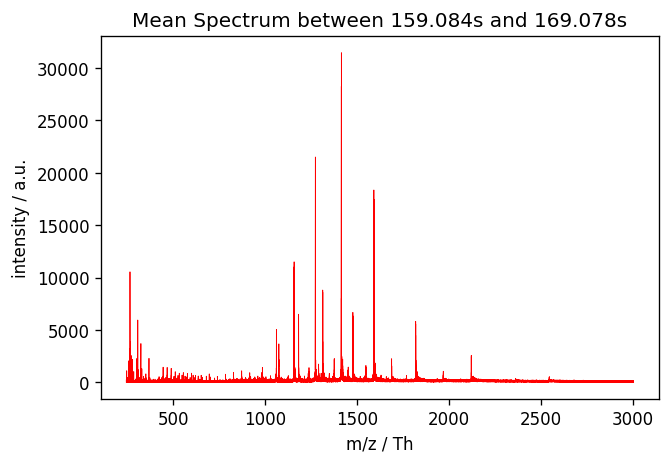

In [3]:
# --- plot mean data within a time window 

# convert resulting spectra values into arrays
np_profile_mz = np.array(spec_vals['profile_mz'])
np_profile_int = np.array(spec_vals['profile_int'])

# np_line_mz = np.array(spec_vals['line_mz'])
# np_line_int = np.array(spec_vals['line_int'])

# take average of arrays 
mean_profile_mz = np.average(np_profile_mz, axis = 0)
mean_profile_int = np.average(np_profile_int, axis = 0)
# mean_line_mz = np.average(np_profile_mz, axis = 0)
# mean_line_int = np.average(np_profile_mz, axis = 0)

plt.figure(dpi = 120)

# plot profile spectrum
plt.plot(mean_profile_mz, mean_profile_int, linewidth = 0.5, color = 'red')

# # plot line spectrum
# plt.stem(line_mz, line_int)

plt.xlabel("m/z / Th")
plt.ylabel('intensity / a.u.')
plt.title("Mean Spectrum between {}s and {}s".format(rt_range[0], rt_range[-1]))
plt.show()

Need to figure out: 
- directly inputting numpy arrays into the unidec engine - raw txt file is created when uploading the data '_rawdata.txt'
- Changing the parameters 
- where everything is!!!



In [4]:
# --- TEMPORARY SOLUTION: make .txt file and subsequently upload into unidec engine 
# begin unidec engine here? 


mean_data = np.array([mean_profile_mz, mean_profile_int]).T
np.savetxt("mean_data1.txt", mean_data, delimiter = "\t")


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  mean_data1.txt
Loading Time: 5.4s
Linear False
Data Prep Time: 0.91s
UniDec run 5.8s
File Name:  mean_data1.txt R Squared:  0.9922255094651705


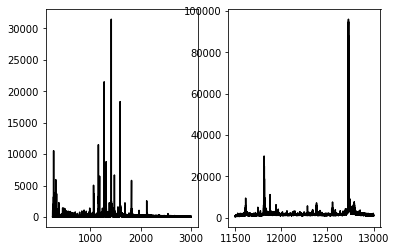

In [5]:
eng1 = unidec.UniDec()
eng1.open_file("mean_data1.txt")


# set params
eng1.config.smooth = 0
eng1.config.subbuff = 0 
eng1.config.massub = 13000
eng1.config.masslb = 11500
eng1.config.massbins = 0.1
eng1.config.peaknorm = 0
eng1.config.datanorm = 0
eng1.config.mzsig  = 0 # this one!!!!!!!
# eng1.config.peakshapeinflate = 1.0 # default?



eng1.process_data()
eng1.run_unidec()
# eng1.pick_peaks()
# eng1.process_mass_data()
eng1.make_plot()

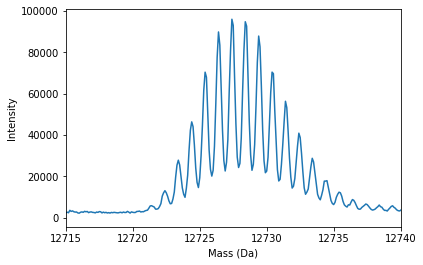

In [6]:
mass_dist_data = np.loadtxt("mean_data1_unidecfiles/mean_data1_mass.txt")

dist_data = mass_dist_data

plt.plot(dist_data[:, 0], dist_data[:, 1])
plt.xlim(12715, 12740)
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity')
plt.show()

In [17]:
eng1.pick_peaks()
eng1.export_params(0)
eng1.peakparams

Exported data to mean_data1_unidecfiles\mean_data1_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.20  0.00  9.34  2.66  29819.62  1392249.89  11813.16  0.70  0.76]
 [ 12727.40  0.00  9.21  1.42  95975.10  1854099.19  12727.41  0.60  0.42]]
Peak Parameters (Saved To mean_data1_unidecfiles\mean_data1_peakparam.dat )


array([[1.18e+04, 0.00e+00, 9.34e+00, 2.66e+00, 2.98e+04, 1.39e+06,
        1.18e+04, 7.00e-01, 7.60e-01],
       [1.27e+04, 0.00e+00, 9.21e+00, 1.42e+00, 9.60e+04, 1.85e+06,
        1.27e+04, 6.01e-01, 4.23e-01]])

In [28]:
# mass_range = [11500.0, 13000.0]

# --- start up unidec engine and load text file


eng = unidec.UniDec()

eng.open_file("mean_data.txt") # change this

eng.process_data()
eng.run_unidec()
eng.pick_peaks()
eng.process_mass_data()





UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
Opening File:  mean_data.txt
Loading Time: 5.3s
396512 1.0
Linear False
Data Prep Time: 0.96s
UniDec run 2.8s
File Name:  mean_data.txt R Squared:  0.9886445190461032
1509 10


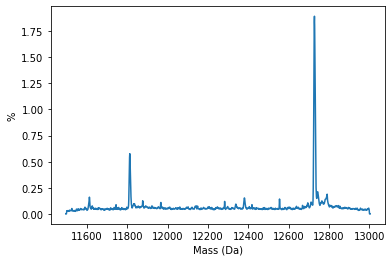

In [30]:
mass_dist_data = np.loadtxt("mean_data_unidecfiles/mean_data_mass.txt")

dist_data = mass_dist_data.T

plt.plot(dist_data[0], dist_data[1])
plt.xlabel('Mass (Da)')
plt.ylabel('%')
plt.show()

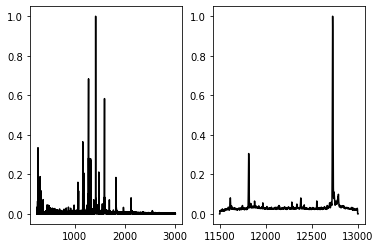

In [7]:
eng.make_plot() # uses self.data.data2[:, 0], self.data.data2[:, 1]
                # self.data.rawdata[:, 0], self.data.rawdata[:, 1]
                # self.data.massdat[:, 0], self.data.massdat[:, 1]

In [8]:
print(eng.data.fitdat.shape, eng.data.baseline.shape, eng.data.fitdat2d.shape, 
      eng.data.rawdata.shape,eng.data.rawdata3.shape, eng.data.data2.shape,
      eng.data.data3.shape,eng.data.massdat.shape,eng.data.mzgrid.shape, 
      eng.data.massgrid.shape, eng.data.ztab.shape, eng.data.massccs.shape, 
      eng.data.ccsz.shape, eng.data.ccsdata.shape)
# data2 = processed data?
# massdat = deconvoluted data


(392765,) (0,) (0,) (396512, 2) (0,) (392765, 2) (0,) (1509, 2) (19638250, 3) (75450,) (50,) (0,) (0,) (0,)


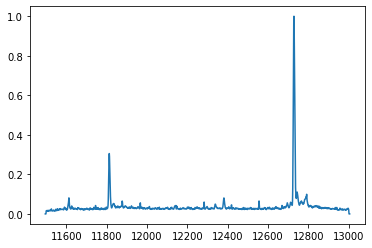

In [12]:
# eng.export_params(e = None)

eng.autorun()

Linear False
Data Prep Time: 0.93s
Automatic Peak Width: 0.03111
UniDec run 2.7s
File Name:  mean_data.txt R Squared:  0.9816190653873914
Exported data to mean_data_unidecfiles\mean_data_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.00  0.29  9.30  2.76  30.54  75.36  11813.39  9.00  3.48]
 [ 12728.00  0.29  9.41  2.29  100.00  100.00  12728.32  9.00  0.09]]
Peak Parameters (Saved To mean_data_unidecfiles\mean_data_peakparam.dat )


In [13]:
eng.peakparams

array([[1.18e+04, 2.89e-01, 9.30e+00, 2.76e+00, 3.05e+01, 7.54e+01,
        1.18e+04, 9.00e+00, 3.48e+00],
       [1.27e+04, 2.93e-01, 9.41e+00, 2.29e+00, 1.00e+02, 1.00e+02,
        1.27e+04, 9.00e+00, 8.91e-02]])

In [14]:
peak_param_names = ["Mass", "MassStdGuess", "AvgCharge", "StdDevCharge", "Height", 
                    "Area", "MassCentroid", "MassFWHM", "MassErrorBetweenZ"]

# get peak info 
for x, y in zip(eng.peakparams, list(range(len(eng.peakparams)))):
    print("~~~~~~~~~~~~~")
    
    print("Peak {}".format(y+1))
    
    for i, j in zip(peak_param_names, x):
        print("{}: {}".format(i, j))
print("~~~~~~~~~~~~~")

~~~~~~~~~~~~~
Peak 1
Mass: 11813.0
MassStdGuess: 0.2891747547487561
AvgCharge: 9.295234803881584
StdDevCharge: 2.760065692286716
Height: 30.540964436340662
Area: 75.35691375420045
MassCentroid: 11813.39077242513
MassFWHM: 9.0
MassErrorBetweenZ: 3.482798072165886
~~~~~~~~~~~~~
Peak 2
Mass: 12728.0
MassStdGuess: 0.29276137678732417
AvgCharge: 9.41052320113546
StdDevCharge: 2.2935476000703474
Height: 100.0
Area: 100.0
MassCentroid: 12728.323078291636
MassFWHM: 9.0
MassErrorBetweenZ: 0.08909934232171109
~~~~~~~~~~~~~


In [27]:
eng1.get_auto_peak_width()
eng1.pick_peaks()
eng1.export_params(0)
eng1.autorun()

Automatic Peak Width: 0.03111
Exported data to mean_data1_unidecfiles\mean_data1_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.20  0.29  9.34  2.66  29819.62  1392249.89  11813.16  0.70  0.76]
 [ 12727.40  0.29  9.21  1.42  95975.10  1854099.19  12727.41  0.60  0.42]]
Peak Parameters (Saved To mean_data1_unidecfiles\mean_data1_peakparam.dat )
Linear False
Data Prep Time: 0.9s
Automatic Peak Width: 0.03111
UniDec run 6.1s
File Name:  mean_data1.txt R Squared:  0.9814049962600995
Exported data to mean_data1_unidecfiles\mean_data1_chargedata.dat
Mass MassStdGuess AvgCharge StdDevCharge Height Area MassCentroid MassFWHM MassErrorBetweenZ
[[ 11813.20  0.29  9.26  2.56  29537.01  1415544.19  11813.16  0.70  0.27]
 [ 12727.40  0.29  9.24  1.70  94696.73  1877726.13  12727.44  0.70  0.33]]
Peak Parameters (Saved To mean_data1_unidecfiles\mean_data1_peakparam.dat )


In [33]:
eng1.run_unidec()
eng1.process_mass_data()
eng1.pick_peaks()

UniDec run 6.1s
File Name:  mean_data1.txt R Squared:  0.9814049962600995


In [35]:
eng1.config.mzsig

0.03111

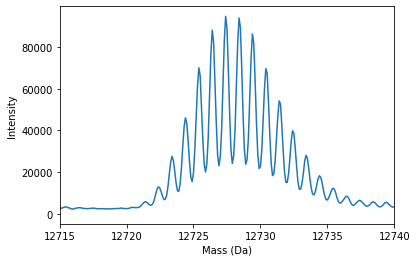

In [34]:
mass_dist_data = np.loadtxt("mean_data1_unidecfiles/mean_data1_mass.txt")

dist_data = mass_dist_data

plt.plot(dist_data[:, 0], dist_data[:, 1])
plt.xlim(12715, 12740)
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity')
plt.show()

In [25]:
peak_param_names = ["Mass", "MassStdGuess", "AvgCharge", "StdDevCharge", "Height", 
                    "Area", "MassCentroid", "MassFWHM", "MassErrorBetweenZ"]

# get peak info 
for x, y in zip(eng1.peakparams, list(range(len(eng1.peakparams)))):
    print("~~~~~~~~~~~~~")
    
    print("Peak {}".format(y+1))
    
    for i, j in zip(peak_param_names, x):
        print("{}: {}".format(i, j))
print("~~~~~~~~~~~~~")

~~~~~~~~~~~~~
Peak 1
Mass: 11813.200195
MassStdGuess: 0.29068286524869313
AvgCharge: 9.343711515547835
StdDevCharge: 2.660081380603362
Height: 29819.617188
Area: 1392249.891693459
MassCentroid: 11813.156534962294
MassFWHM: 0.7001949999994395
MassErrorBetweenZ: 0.7595671041276918
~~~~~~~~~~~~~
Peak 2
Mass: 12727.400391
MassStdGuess: 0.28655436068263945
AvgCharge: 9.211004843543538
StdDevCharge: 1.4205831613245556
Height: 95975.101563
Area: 1854099.186135805
MassCentroid: 12727.406605130844
MassFWHM: 0.6005859999986569
MassErrorBetweenZ: 0.4227469255832586
~~~~~~~~~~~~~


In [15]:
# help(eng.config)

In [17]:
eng.config.print_config()

version 4.4.0
imflag 0
input mean_data_unidecfiles\mean_data_input.dat
output mean_data_unidecfiles\mean_data
numit 100
numz 50
endz 50
startz 1
zzsig 1.0
psig 1.0
beta 0.0
mzsig 0.03111
psfun 0
discreteplot 0
massub 13000.0
masslb 11500.0
msig 0.0
molig 0.0
massbins 1.0
mtabsig 0.0
minmz 244.9952986816976
maxmz 3005.214276390133
subbuff 0.0
subtype 2
smooth 0.0
mzbins 0.0
peakwindow 500.0
peakthresh 0.1
peakplotthresh 0.1
plotsep 0.025
intthresh 0.0
reductionpercent 0.0
aggressive 0
rawflag 0
adductmass 1.007276467
nativezub 1000.0
nativezlb -1000.0
poolflag 2
accvol 0.0
peakshapeinflate 1.0
noiseflag 0.0
linflag 2
cmap nipy_spectral
peakcmap rainbow
spectracmap rainbow
publicationmode 1
isotopemode 0
peaknorm 1.0
datanorm 1.0
baselineflag 1.0
orbimode 0.0
filterwidth 20.0
zerolog -12.0



In [20]:
class BrukerAnalysis(unidec.UniDec): 
    def __init__(self, filename, t_window = 10):
        super().__init__()
        self.filename = filename
        self.t_window = t_window
        
    def upload_data(self):
        analysis_dir = self.filename

        # --- data extraction using baf2sql DLL 

        if sys.version_info.major == 2:
            # note: assuming a european Windows here...
            analysis_dir = unicode(analysis_dir, 'cp1252')

        baf_fn = os.path.join(analysis_dir, "analysis.baf")
        sqlite_fn = baf2sql.getSQLiteCacheFilename(baf_fn)
        conn = sqlite3.connect(sqlite_fn)

        # --- Count spectra
        q = conn.execute("SELECT COUNT(*) FROM Spectra "
                         "WHERE LineMzId NOT NULL AND ProfileMzId NOT NULL")
        row = q.fetchone()
        N = row[0]
        print("Specified BAF has {} spectra with line and profile data.".format(N))

        # --- Plot TIC and BPC over MS^1 spectra
        q = conn.execute("SELECT Rt, SumIntensity, MaxIntensity FROM Spectra s "
                         "JOIN AcquisitionKeys ak ON s.AcquisitionKey = ak.Id "
                         "WHERE ak.MsLevel = 0 "
                         "ORDER BY s.ROWID")
        data = [ row for row in q ]
        rt = [ row[0] for row in data ]
        tic = [ row[1] for row in data ]
        bpc = [ row[2] for row in data ]

        # --- mean spectrum within time window

        np_bpc = np.array(bpc, dtype = 'float')

        # get time window around base-peak intensity 
        if (self.t_window % 2 )== 0:
        
            rt_range = rt[np.nanargmax(np_bpc) - (self.t_window/2): np.nanargmax(np_bpc) + (self.t_window/2)+1]
        else:
            rt_range = rt[np.nanargmax(np_bpc) - (self.t_window/2)-0.5: np.nanargmax(np_bpc) + (self.t_window/2)+0.5]

        spec_vals = {'profile_mz':[], 'profile_int':[], 'line_mz':[], 'line_int':[]}

        for i in rt_range: 

            q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                            "WHERE ABS(Rt - {}) < 1e-8".format(i))

            row = q.fetchone()

            bs = baf2sql.BinaryStorage(baf_fn)

            if not all(row) == False: # check for None values

                bs = baf2sql.BinaryStorage(baf_fn)

                profile_mz = bs.readArrayDouble(row[2])
                profile_int = bs.readArrayDouble(row[3])

                spec_vals['profile_mz'].append(profile_mz)
                spec_vals['profile_int'].append(profile_int)


                line_mz = bs.readArrayDouble(row[0])
                line_int = bs.readArrayDouble(row[1])

                # stem() can take quite some time, so we reduce data for this example:

                max_points = 100;

                if len(line_mz) > max_points:
                    line_mz = line_mz[0:max_points]
                    line_int = line_int[0:max_points]

                spec_vals['line_mz'].append(line_mz)
                spec_vals['line_int'].append(line_int)

        # convert resulting spectra values into arrays
        self.profile_mz = np.array(spec_vals['profile_mz'])
        self.profile_int = np.array(spec_vals['profile_int'])
        
    def plot_raw_data():
        pass

In [21]:
eng2 = BrukerAnalysis("example_analysis.d")
# eng2.upload_data()
# eng2.profile_mz


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\MS-Analysis\UniDec\unidec_bin\UniDec.exe
